In [1]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from itertools import chain
from functools import partial
from collections import defaultdict


from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

gc.collect()

# Dataset

In [3]:
from scripts.utils import load_datasets

train_df, val_df, test_df = load_datasets()

In [4]:
train_df.head()

,id,text_en,text_fr,label,label_text
0,3232343436343136,Has Angelika Kratzer video messaged me?,Angelika Kratzer m'a-t-elle envoyé un message ...,0,messaging
1,3132353830343836,Maricopa County weather forecast for this week,Prévision météo pour le comté de Maricopa cett...,5,weather
2,3136363730313437,When will my next alarm start,Quand est-ce que ma prochaine alarme va sonner,6,alarm
3,3232353833343937,text Matthew and Helen that are you free,envoyez un texto à Matthew et Helen pour leur ...,0,messaging
4,3231333432363134,I am no longer available,Je ne suis plus disponible,1,calling


In [5]:
len(train_df), len(val_df), len(test_df)

(11814, 1577, 3193)

In [ ]:
train_df.to_csv("../data/mtob_domain_en_fr_train.csv", index=False)
val_df.to_csv("../data/mtob_domain_en_fr_val.csv", index=False)
test_df.to_csv("../data/mtob_domain_en_fr_test.csv", index=False)

In [6]:
df = pd.concat([train_df.assign(split="train"), val_df.assign(split="val"), test_df.assign(split="test")], ignore_index=True)

In [7]:
print(df.groupby(["label_text", "split"]).size().unstack(level=1)[["train", "val", "test"]].to_markdown())

| label_text   |   train |   val |   test |
|:-------------|--------:|------:|-------:|
| alarm        |    1113 |   138 |    330 |
| calling      |    1968 |   278 |    551 |
| event        |     799 |    92 |    159 |
| messaging    |     861 |   125 |    253 |
| music        |    1082 |   137 |    280 |
| news         |     668 |    78 |    159 |
| people       |     975 |   145 |    272 |
| recipes      |     697 |   124 |    181 |
| reminder     |    1656 |   203 |    462 |
| timer        |     734 |    89 |    190 |
| weather      |    1261 |   168 |    356 |


In [8]:
id2label = train_df[["label", "label_text"]].set_index("label")["label_text"].sort_index().to_dict()
label2id = {l: i for i, l in id2label.items()}
class_names = list(label2id.keys())
id2label

{0: 'messaging',
 1: 'calling',
 2: 'event',
 3: 'timer',
 4: 'music',
 5: 'weather',
 6: 'alarm',
 7: 'people',
 8: 'reminder',
 9: 'recipes',
 10: 'news'}

# Baselines

- English & French


In [9]:
def evaluate(true, preds, metric="micro_f1"):
    metric_func = {
        "micro_f1": partial(f1_score, average="micro"),
        "macro_f1": partial(f1_score, average="macro"),
        "weighted_f1": partial(f1_score, average="weighted"),
    }
    score = metric_func[metric](true, preds)
    return score

In [10]:
def display_scores(scores_df):
    scores_df = scores_df.set_index(["model", "language", "split"]).unstack(level=2)
    scores_df.columns = scores_df.columns.swaplevel(0, 1)
    scores_df = scores_df.sort_index(axis=1, level=0).rename_axis(["", ""], axis=1)
    return scores_df

In [11]:
scores_df = pd.DataFrame(columns=["model", "language", "split", "micro_f1", "macro_f1", "weighted_f1"])
scores_df

,model,language,split,micro_f1,macro_f1,weighted_f1


## 1. Most frequent class

In [12]:
most_freq_cls = train_df.label.value_counts().index[0]
most_freq_cls, id2label[most_freq_cls]

(1, 'calling')

In [13]:
model_name = "base1_mostfreq"

base0_clf = DummyClassifier(strategy="most_frequent", random_state=630).fit(
    X=[None] * len(train_df), y=train_df["label"].values)

base0_preds = defaultdict(dict)
base0_scores = []

for split in ["train", "val"]:
    split_df = df.query("split == @split")
    base0_preds[split] = base0_clf.predict([None] * len(split_df))
    
    micro_f1 = evaluate(split_df["label"].values, base0_preds[split], "micro_f1")
    macro_f1 = evaluate(split_df["label"].values, base0_preds[split], "macro_f1")
    weighted_f1 = evaluate(split_df["label"].values, base0_preds[split], "weighted_f1")
        
    base0_scores.append([model_name, "en", split, micro_f1, macro_f1, weighted_f1])
    base0_scores.append([model_name, "fr", split, micro_f1, macro_f1, weighted_f1])

scores_df = pd.concat([scores_df, pd.DataFrame(base0_scores, columns=scores_df.columns)], ignore_index=True)
display_scores(scores_df)

train                             val            \
                         macro_f1  micro_f1 weighted_f1  macro_f1  micro_f1   
model          language                                                       
base1_mostfreq en        0.025963  0.166582    0.047574  0.027248  0.176284   
               fr        0.025963  0.166582    0.047574  0.027248  0.176284   

                                     
                        weighted_f1  
model          language              
base1_mostfreq en          0.052838  
               fr          0.052838

## 2. Stratified

Randomly sample from a prior defined by the train set distribution.

In [14]:
train_counts = train_df.label_text.value_counts()

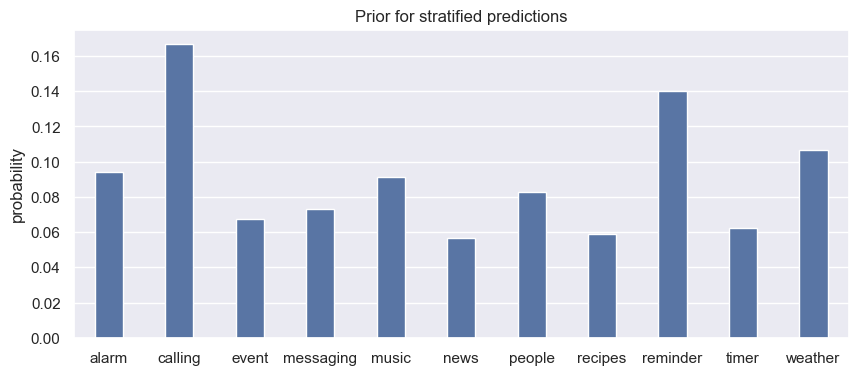

In [15]:
plt.figure(figsize=(10, 4))
sns.countplot(data=train_df, x="label_text", order=sorted(train_counts.index), stat="probability", width=0.4)
plt.xlabel("");
plt.title("Prior for stratified predictions");

In [16]:
model_name = "base2_stratified"

base1_clf = DummyClassifier(strategy="stratified", random_state=630).fit(
    X=[None] * len(train_df), y=train_df["label"].values)

base1_preds = defaultdict(dict)
base1_scores = []

for split in ["train", "val"]:
    split_df = df.query("split == @split")
    base1_preds[split] = base1_clf.predict([None] * len(split_df))
    
    micro_f1 = evaluate(split_df["label"].values, base1_preds[split], "micro_f1")
    macro_f1 = evaluate(split_df["label"].values, base1_preds[split], "macro_f1")
    weighted_f1 = evaluate(split_df["label"].values, base1_preds[split], "weighted_f1")
        
    base1_scores.append([model_name, "en", split, micro_f1, macro_f1, weighted_f1])
    base1_scores.append([model_name, "fr", split, micro_f1, macro_f1, weighted_f1])

scores_df = pd.concat([scores_df, pd.DataFrame(base1_scores, columns=scores_df.columns)], ignore_index=True)
display_scores(scores_df)

train                             val            \
                           macro_f1  micro_f1 weighted_f1  macro_f1  micro_f1   
model            language                                                       
base1_mostfreq   en        0.025963  0.166582    0.047574  0.027248  0.176284   
                 fr        0.025963  0.166582    0.047574  0.027248  0.176284   
base2_stratified en        0.090648  0.103013    0.103020  0.081497  0.094483   
                 fr        0.090648  0.103013    0.103020  0.081497  0.094483   

                                       
                          weighted_f1  
model            language              
base1_mostfreq   en          0.052838  
                 fr          0.052838  
base2_stratified en          0.094554  
                 fr          0.094554

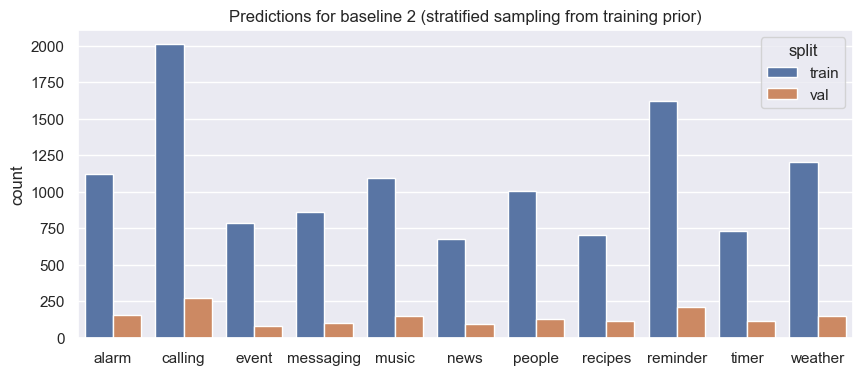

In [17]:
base1_preds_counts = {split: pd.value_counts([id2label[p] for p in preds]) for split, preds in base1_preds.items()}
base1_preds_counts = pd.DataFrame(base1_preds_counts)\
    .melt(var_name="split", value_name="count", ignore_index=False)\
    .rename_axis("label_text").reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(data=base1_preds_counts, x="label_text", y="count", hue="split", order=sorted(train_counts.index))
plt.xlabel("")
plt.title("Predictions for baseline 2 (stratified sampling from training prior)");

## 3. Naive rule based classifier 

- Define a list of keywords per class based on most frequently occuring words.
- Check for the presence of a keyword in the query text.
- If none of the keywords corresponding to any class are present, predict "unknown". In this case, we would expect the voice assistant to say something like "Sorry, I could not catch that" or "Sorry, instructions unclear". Falling back to the most frequent class in the training set is not a very sound strategy in this case.

Most frequent words per class:

In [18]:
def get_freq_words_per_class(df, lang, n=3):
    text_col = f"text_{lang}"
    words = df[["label_text", text_col]]
    words[text_col] = words[text_col].map(lambda s: s.lower().split())
    words = words.groupby("label_text").apply(lambda grp: list(chain.from_iterable(grp[text_col].values)))
    words = words.map(lambda w: pd.value_counts(w).head(n).index.values)
    return words

In [19]:
freq_words_en = get_freq_words_per_class(train_df, "en", 5)
freq_words_en

label_text
alarm               [alarm, for, set, an, at]
calling           [call, to, my, the, please]
event              [in, to, this, events, do]
messaging       [message, to, video, a, send]
music               [play, the, to, song, on]
news         [the, news, me, what, headlines]
people           [who, is, in, friends, does]
recipes             [how, a, i, what, recipe]
reminder           [to, me, remind, the, for]
timer         [timer, the, for, minutes, set]
weather          [the, is, weather, in, what]
dtype: object

In [20]:
freq_words_fr = get_freq_words_per_class(train_df, "fr", 5)
freq_words_fr

label_text
alarm              [alarme, pour, une, à, les]
calling            [appelle, de, à, appel, en]
event                   [à, ce, de, faire, se]
messaging        [à, message, un, vidéo, pour]
music             [de, la, joue, chanson, sur]
news                 [les, de, ?, sur, titres]
people                    [?, de, qui, à, que]
recipes              [de, la, recette, une, ?]
reminder             [de, pour, le, à, rappel]
timer        [minuterie, la, de, minutes, une]
weather                  [?, à, la, de, temps]
dtype: object

In [21]:
# Select keywords from EN train set
# Assume FR training set is not available and use human translated EN labels

keywords = {
    "en": {
        "alarm": "alarm",
        "calling": "call",
        "event": "event", 
        "messaging": "message",
        "music": "play",
        "news": "news",
        "people": "who",
        "recipes": "recipe",
        "reminder": "remind",
        "timer": "timer", 
        "weather": "weather",
    },
    "fr": { # translate keywords from english
        "alarm": "alarme",
        "calling": "appel",
        "event": "événement",
        "messaging": "message",
        "music": "joue",
        "news": "nouvelles",
        "people": "qui",
        "recipes": "recette",
        "reminder": "rappel",
        "timer": "minuterie", 
        "weather": "temps",
    }
}

# When keywords corresponding to more than one class are present, give priority to the rarer class
# Sort classes in increasing order of frequency in the training set 
# Iterate through the keywords dictionary in this order and predict the first matched class
labels_sorted_by_freq = train_df.label_text.value_counts().sort_values(ascending=True).index
labels_sorted_by_freq

Index(['news', 'recipes', 'timer', 'event', 'messaging', 'people', 'music',
       'alarm', 'weather', 'reminder', 'calling'],
      dtype='object', name='label_text')

In [22]:
keywords_df = pd.DataFrame(keywords)
keywords_df.columns = ["Keyword_EN", "Keyword_FR"]
keywords_df = keywords_df.rename_axis("Label")
print(keywords_df.to_markdown())

| Label     | Keyword_EN   | Keyword_FR   |
|:----------|:-------------|:-------------|
| alarm     | alarm        | alarme       |
| calling   | call         | appel        |
| event     | event        | événement    |
| messaging | message      | message      |
| music     | play         | joue         |
| news      | news         | nouvelles    |
| people    | who          | qui          |
| recipes   | recipe       | recette      |
| reminder  | remind       | rappel       |
| timer     | timer        | minuterie    |
| weather   | weather      | temps        |


In [23]:
def predict(
    texts, keywords_by_label, 
    labels_ordered=labels_sorted_by_freq,
    label2id=label2id, 
    unknown_class_id=-1,
):
    pred_labels = []
    for text in texts:
        text = text.lower()
        label_found = False
        for label in labels_ordered:
            if keywords_by_label[label] in text:
                pred_labels.append(label)
                label_found = True
                break
                
        if not label_found:
            pred_labels.append(None)
        
    return [label2id.get(l, unknown_class_id) for l in pred_labels]

In [24]:
model_name = "base3_keywords"

base3_preds = defaultdict(lambda: defaultdict(dict))
scores = []

for lang in ["en", "fr"]:
    text_col = f"text_{lang}"
    
    for split in ["train", "val"]:
        split_df = df.query("split == @split")
        base3_preds[lang][split] = predict(split_df[text_col].values, keywords[lang])
        
        micro_f1 = evaluate(split_df["label"].values, base3_preds[lang][split], "micro_f1")
        macro_f1 = evaluate(split_df["label"].values, base3_preds[lang][split], "macro_f1")
        weighted_f1 = evaluate(split_df["label"].values, base3_preds[lang][split], "weighted_f1")
        
        scores.append([model_name, lang, split, micro_f1, macro_f1, weighted_f1])
            
scores_df = pd.concat([scores_df, pd.DataFrame(scores, columns=scores_df.columns)], ignore_index=True)

In [25]:
disp_scores_df = display_scores(scores_df)

In [26]:
print(disp_scores_df.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 &  & \multicolumn{3}{r}{train} & \multicolumn{3}{r}{val} \\
 &  & macro_f1 & micro_f1 & weighted_f1 & macro_f1 & micro_f1 & weighted_f1 \\
model & language &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{base1_mostfreq} & en & 0.03 & 0.17 & 0.05 & 0.03 & 0.18 & 0.05 \\
 & fr & 0.03 & 0.17 & 0.05 & 0.03 & 0.18 & 0.05 \\
\cline{1-8}
\multirow[t]{2}{*}{base2_stratified} & en & 0.09 & 0.10 & 0.10 & 0.08 & 0.09 & 0.09 \\
 & fr & 0.09 & 0.10 & 0.10 & 0.08 & 0.09 & 0.09 \\
\cline{1-8}
\multirow[t]{2}{*}{base3_keywords} & en & 0.65 & 0.63 & 0.74 & 0.64 & 0.62 & 0.72 \\
 & fr & 0.56 & 0.54 & 0.65 & 0.56 & 0.55 & 0.65 \\
\cline{1-8}
\bottomrule
\end{tabular}



- Much lower for french

Correctly predicted:

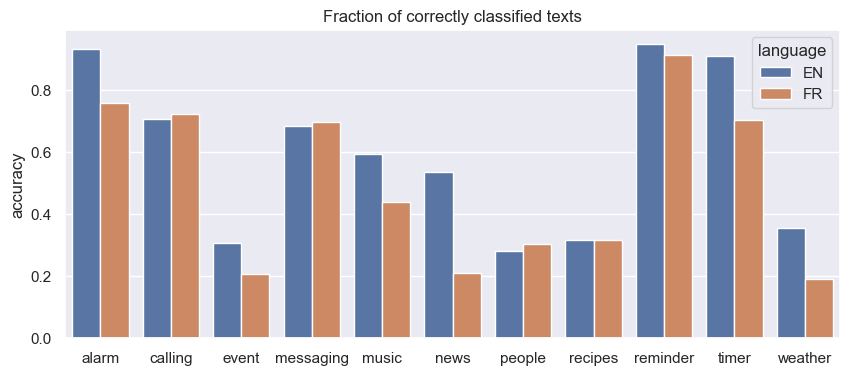

In [27]:
corr_fracs_df = []

for lang in ["en", "fr"]:
    text_col = f"text_{lang}"
    
    lang_df = []
    for split in ["train", "val"]:
        split_df = df.query("split == @split")
        split_df["pred"] = base3_preds[lang][split]
        lang_df.append(split_df)

    lang_df = pd.concat(lang_df, ignore_index=True)
    corr_frac = lang_df.groupby("label_text").apply(lambda grp: (grp.pred == grp.label).mean())\
        .rename("corr_frac").reset_index()
    
    corr_fracs_df.append(corr_frac.assign(language=lang.upper()))
    
corr_fracs_df = pd.concat(corr_fracs_df, ignore_index=True)

plt.figure(figsize=(10, 4))
sns.barplot(data=corr_fracs_df, x="label_text", y="corr_frac", hue="language")
plt.title(f"Fraction of correctly classified texts")
plt.xlabel("")
plt.ylabel("accuracy");

No. of misclassifications:

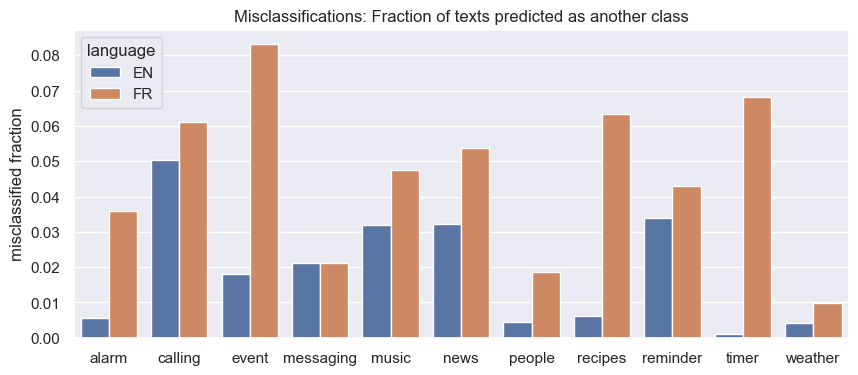

In [28]:
mis_fracs_df = []

for lang in ["en", "fr"]:
    text_col = f"text_{lang}"
    
    lang_df = []
    for split in ["train", "val"]:
        split_df = df.query("split == @split")
        split_df["pred"] = base3_preds[lang][split]
        lang_df.append(split_df)

    lang_df = pd.concat(lang_df, ignore_index=True)
    mis_frac = lang_df.groupby("label_text").apply(lambda grp: ((grp.pred >= 0) & (grp.pred != grp.label)).mean())\
        .rename("mis_frac").reset_index()
    
    mis_fracs_df.append(mis_frac.assign(language=lang.upper()))
    
mis_fracs_df = pd.concat(mis_fracs_df, ignore_index=True)

plt.figure(figsize=(10, 4))
sns.barplot(data=mis_fracs_df, x="label_text", y="mis_frac", hue="language")
plt.title(f"Misclassifications: Fraction of texts predicted as another class")
plt.xlabel("")
plt.ylabel("misclassified fraction");

- Misclassifications make up less than 1% of the errors.
- The vast majority of errors seem to be texts classified as "unknown".

No. of "unknown" predictions:

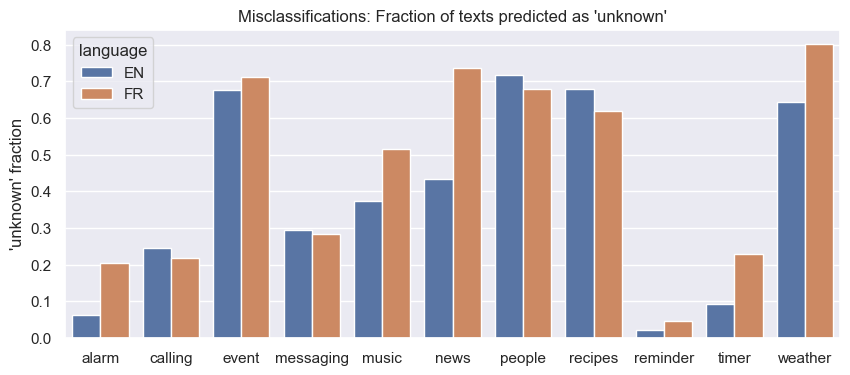

In [29]:
unk_fracs_df = []

for lang in ["en", "fr"]:
    text_col = f"text_{lang}"
    
    lang_df = []
    for split in ["train", "val"]:
        split_df = df.query("split == @split")
        split_df["pred"] = base3_preds[lang][split]
        lang_df.append(split_df)

    lang_df = pd.concat(lang_df, ignore_index=True)    
    unk_frac = lang_df.groupby("label_text").apply(lambda grp: (grp.pred < 0).mean())\
        .rename("unk_frac").reset_index()
    
    unk_fracs_df.append(unk_frac.assign(language=lang.upper()))
    
unk_fracs_df = pd.concat(unk_fracs_df, ignore_index=True)

plt.figure(figsize=(10, 4))
sns.barplot(data=unk_fracs_df, x="label_text", y="unk_frac", hue="language")
# plt.title(f"{lang.upper()}: fraction of texts predicted as 'unknown'")
plt.title(f"Misclassifications: Fraction of texts predicted as 'unknown'")
plt.xlabel("")
plt.ylabel("'unknown' fraction");

This gives us some rough idea of the complexity of different classes for the text classification task in each language. Higher the fraction of texts predicted as "unknown", more complex is that class. In general, "alarm", "reminder", and "timer" seem to be relatively straight forward.

For most classes, the naive method does much better for English than French, the difference being particularly large for "alarm", "timer", "news" and "music".


# Predict on test set

In [37]:
os.listdir("../outputs/baselines/")

['.ipynb_checkpoints', 'base1_mostfreq', 'base2_stratified', 'base3_keywords']

In [38]:
base1_preds_df = test_df[["id"]]
base1_preds = base0_clf.predict_proba([None] * len(test_df))
base1_preds_df["label"] = base1_preds.argmax(1)
base1_preds_df["score"] = base1_preds.max(1)

base1_preds_df.to_csv("../outputs/baselines/base1_mostfreq/test_preds.csv", index=False)

In [39]:
base2_preds_df = test_df[["id"]]
base2_preds = base1_clf.predict_proba([None] * len(test_df))
base2_preds_df["label"] = base2_preds.argmax(1)
base2_preds_df["score"] = base2_preds.max(1)

base2_preds_df.to_csv("../outputs/baselines/base2_stratified/test_preds.csv", index=False)

In [41]:
base3_preds_df = test_df[["id"]]
base3_preds_df["label"] = predict(test_df["text_fr"].values, keywords["fr"])
base3_preds_df["score"] = 1.

base3_preds_df.to_csv("../outputs/baselines/base3_keywords/test_preds.csv", index=False)